In [1]:
import os, sys

import matplotlib.pyplot as plt
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import numpy as np
from scipy.spatial import distance_matrix
from src.aco import Colony
from src.graph import Graph

In [2]:
def read_tsp_file(file_path: str) -> np.ndarray:
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        num_cities = int(lines[0])
        coords = []
        for line in lines[1:num_cities+1]:
            x, y = map(float, line.split())
            coords.append([x, y])
        
        return np.array(coords)



In [3]:
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from src.graph import Graph
from src.output import Output

def run_experiment(aco_type: str, generations: int = 100):
    coords = read_tsp_file('../data/tsp_51_1')
    graph = Graph(distance_matrix=distance_matrix(coords, coords), points=coords, eval_nn=True)
    aco = Colony(
        graph=graph,
        ant_count=50,
        generations=generations,
        type=aco_type,
        top=5,
        alpha=1,
        beta=2,
        rho=0.1,
        q0=0.9,
        phi=0.1
    )
    output: Output = aco.run()
    return output.history


types = ['as', 'eas', 'as_rank', 'mmas', 'acs']
histories = {t: run_experiment(t, generations=5000) for t in types}




50 / 51
0 482.6158644827013
1 482.6158644827013
2 477.6053617925566
3 477.6053617925566
4 477.6053617925566
5 477.6053617925566
6 477.6053617925566
7 477.6053617925566
8 477.6053617925566
9 477.6053617925566
10 477.60536179255655
11 477.60536179255655
12 477.60536179255655
13 472.52154718947565
14 472.52154718947565
15 472.52154718947565
16 467.3924272591572
17 467.3924272591572
18 466.00837715378196
19 466.0083771537819
20 466.0083771537819
21 465.40441497939526
22 465.40441497939526
23 465.40441497939526
24 465.40441497939526
25 465.40441497939526
26 465.40441497939526
27 465.40441497939526
28 465.40441497939526
29 465.40441497939526
30 465.40441497939526
31 465.40441497939526
32 465.40441497939526
33 465.40441497939526
34 465.40441497939526
35 465.40441497939526
36 465.40441497939526
37 465.40441497939526
38 465.40441497939526
39 465.40441497939526
40 465.40441497939514
41 465.40441497939514
42 465.40441497939514
43 465.40441497939514
44 465.40441497939514
45 465.40441497939514
46 4

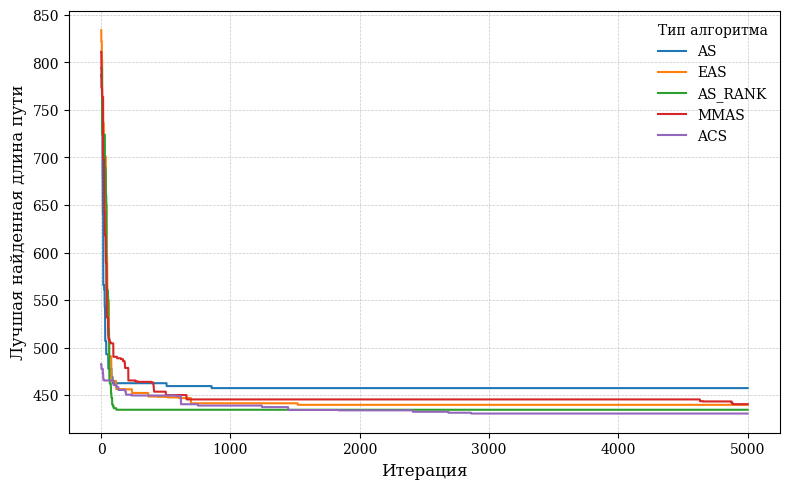

In [5]:
plt.style.use('default')
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')

for algo_type, history in histories.items():
    ax.plot(
        range(1, len(history) + 1),
        history,
        label=algo_type.upper(),
        linewidth=1.5
    )

ax.set_xlabel('Итерация', fontsize=12)
ax.set_ylabel('Лучшая найденная длина пути', fontsize=12)
ax.legend(title='Тип алгоритма', frameon=False)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('aco_comparison.pdf', format='pdf', dpi=300)
plt.show()

In [6]:
import time
import random
import concurrent
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from multiprocessing import current_process

datasets = ['tsp_51_1', 'tsp_100_3', 'tsp_200_2']
types = ['as', 'eas', 'as_rank', 'mmas', 'acs']
n_runs = 10
generations = 5000

def run_experiment(aco_type: str, filename: str, generations: int, seed):
    coords = read_tsp_file(f'../data/{filename}')
    dist_mat = distance_matrix(coords, coords)
    graph = Graph(distance_matrix=dist_mat, points=coords, eval_nn=True)
    random.seed(seed)
    np.random.seed(seed)
    aco = Colony(
        graph=graph,
        ant_count=50,
        generations=generations,
        type=aco_type,
        top=5,
        alpha=1,
        beta=2,
        rho=0.1,
        q0=0.9,
        phi=0.1
    )
    output = aco.run()
    return output.best_dist, output.overall_time

def wrapper_run_experiment(args):
    t, ds, gen, run_id = args
    process_id = current_process().pid
    seed = process_id + run_id + int(time.time_ns() % 1e6)
    bd, tm = run_experiment(t, ds, gen, seed)
    return (ds, t, bd, tm)

if __name__ == '__main__':
    tasks = [(t, ds, generations, run_id) for ds in datasets for t in types for run_id in range(n_runs)]
    total_tasks = len(tasks)
    
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(wrapper_run_experiment, task) for task in tasks]
        
        results = []
        completed = 0
        print("Прогресс выполнения:")
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
            completed += 1
            progress = completed / total_tasks * 100
            print(f"\r{progress:.1f}% ({completed}/{total_tasks})", end="", flush=True)
    
    
    grouped = defaultdict(lambda: {'dists': [], 'times': []})
    for ds, t, bd, tm in results:
        grouped[(ds, t)]['dists'].append(bd)
        grouped[(ds, t)]['times'].append(tm)
    
    
    records = []
    for (ds, t), data in grouped.items():
        records.append({
            'Dataset': ds,
            'Algorithm': t,
            'Mean Best Distance': np.mean(data['dists']),
            'Min Best Distance': np.min(data['dists']),
            'Mean Time (s)': np.mean(data['times']),
        })
    
    df = pd.DataFrame(records)
    print("\n\nРезультаты:")
    print(df)
    
    with open('aco_summary_multi.tex', 'w') as f:
        f.write(df.to_latex(
            index=False,
            float_format="%.2f",
            caption="Сводная статистика ACO-алгоритмов по трём TSP наборам (10 запусков по 5000 итераций)",
            label="tab:aco_summary_multi",
        ))

Прогресс выполнения:
100.0% (150/150)

Результаты:
      Dataset Algorithm  Mean Best Distance  Min Best Distance  Mean Time (s)
0    tsp_51_1        as          447.715067         441.755772    1760.650958
1    tsp_51_1       eas          441.025625         436.794645    1810.354818
2    tsp_51_1   as_rank          434.652614         431.611828    1258.303426
3    tsp_51_1      mmas          441.040557         428.981647    1226.873727
4    tsp_51_1       acs          433.970884         428.981647     618.556178
5   tsp_100_3        as        21611.065000       21449.834339    1675.951484
6   tsp_100_3       eas        21440.467879       21410.993263    1491.037888
7   tsp_100_3   as_rank        21751.346710       21368.693720    1543.746164
8   tsp_100_3      mmas        21376.420017       21108.049881    1556.399209
9   tsp_100_3       acs        21004.777667       20750.762504    1054.376994
10  tsp_200_2        as        32719.256632       31902.338452    3177.322560
11  tsp_200_2